# News Ranker Using Logistic regression

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams

plt.rcParams['figure.figsize'] = [10, 10]
import seaborn as sns

sns.set_theme(style="darkgrid")

import nltk
from nltk import sent_tokenize
from nltk.corpus import stopwords

stopwords = nltk.corpus.stopwords.words('english')
from nltk.tokenize import word_tokenize
import contractions
import string
import joblib
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV


In [39]:
# Data Pre Processing
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [40]:
print("Null values in training set: ")
print(train_df.isna().sum())
print("Null values in test set: ")
print(test_df.isna().sum())

Null values in training set: 
id           0
title      558
author    1957
text        39
label        0
dtype: int64
Null values in test set: 
id          0
title     122
author    503
text        7
dtype: int64


In [41]:
train_df.dropna(axis=0, how='any', inplace=True)
test_df = test_df.fillna(' ')

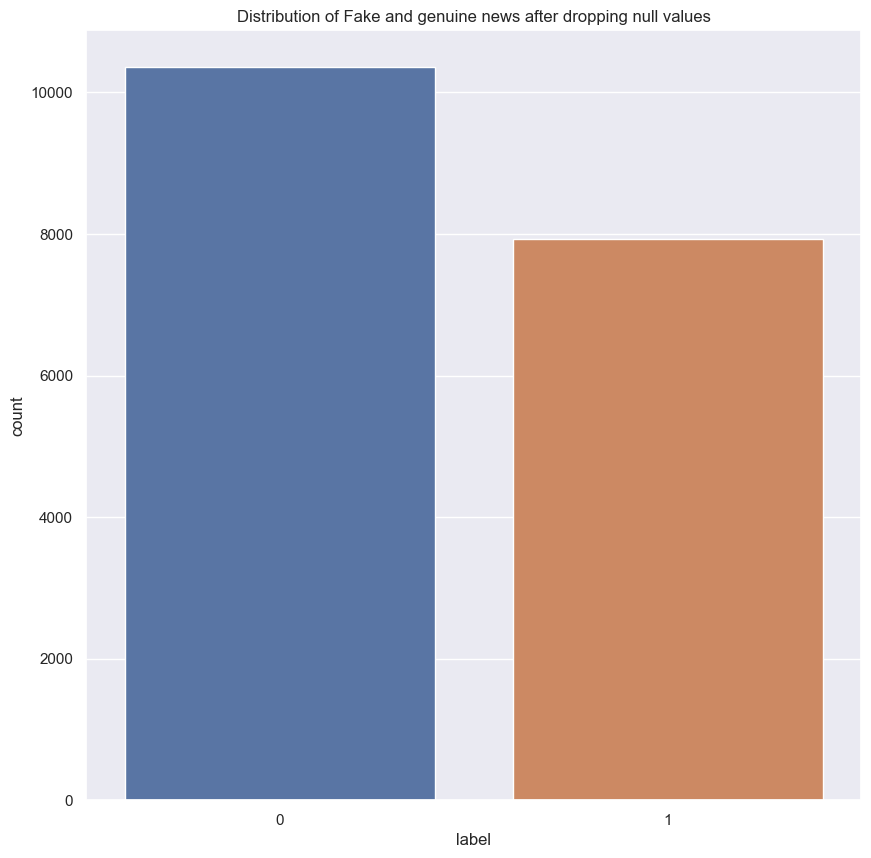

In [42]:
# See the distribution in dataset
import matplotlib.pyplot as plt
# from matplotlib import rcParams
# plt.rcParams['figure.figsize'] = [10,10]
import seaborn as sns

sns.set_theme(style="darkgrid")
sns.countplot(x='label', data=train_df).set(title="Distribution of Fake and genuine news after dropping null values")
plt.show()

<Axes: xlabel='label', ylabel='raw_text_length'>

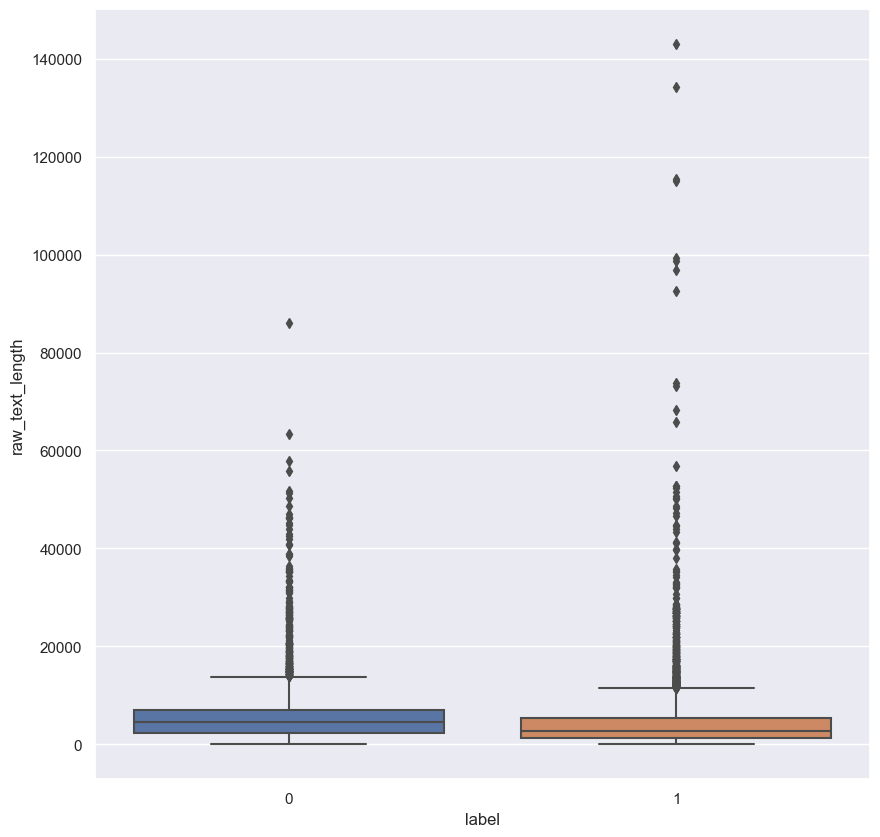

In [43]:
# Check article length
train_df['raw_text_length'] = train_df['text'].apply(lambda x: len(x))
sns.boxplot(y='raw_text_length', x='label', data=train_df)

In [44]:
# Remove Entries whose text size is 0 after stripping
train_df['text'] = train_df['text'].str.strip()
train_df['raw_text_length'] = train_df['text'].apply(lambda x: len(x))
print(len(train_df[train_df['raw_text_length'] == 0]))
# print(train_df['raw_text_length']==0)

74


116
id                 0
title              0
author             0
text               0
label              0
raw_text_length    0
dtype: int64
(20684, 6)
id                 0
title              0
author             0
text               0
label              0
raw_text_length    0
dtype: int64


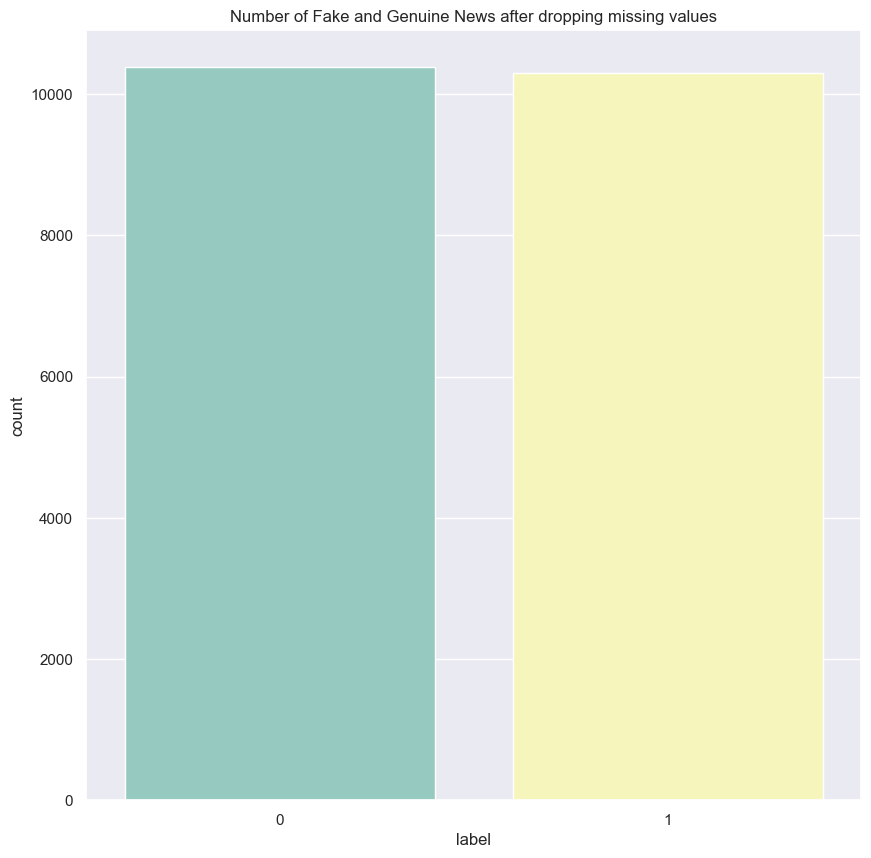

In [45]:
#Data Cleaning Combined
train_df = pd.read_csv('data/train.csv', header=0)
train_df = train_df.fillna(' ')
train_df['text'] = train_df['text'].str.strip()
train_df['raw_text_length'] = train_df['text'].apply(lambda x: len(x))
print(len(train_df[train_df['raw_text_length'] == 0]))
print(train_df.isna().sum())
train_df = train_df[train_df['raw_text_length'] > 0]
print(train_df.shape)
print(train_df.isna().sum())

# Visualize the target's distribution
sns.countplot(x='label', data=train_df, palette='Set3')
plt.title("Number of Fake and Genuine News after dropping missing values")
plt.show()

In [46]:
# Checking how individual features help in labelling data
gen_news_authors = set(list(train_df[train_df['label'] == 0]['author'].unique()))
fake_news_authors = set(list(train_df[train_df['label'] == 1]['author'].unique()))
overlapped_authors = gen_news_authors.intersection(fake_news_authors)
print("Number of distinct authors with genuine articles: {}".format(len(gen_news_authors)))
print("Number of distinct authors with fake articles: {}".format(len(fake_news_authors)))
print("Number of distinct authors with both genuine and fake: {}".format(len(overlapped_authors)))

Number of distinct authors with genuine articles: 2226
Number of distinct authors with fake articles: 1976
Number of distinct authors with both genuine and fake: 6


## Text Cleaning

In [47]:
from nltk import sent_tokenize
original_train_df = train_df.copy()

In [48]:
# Preserve only the Latin character, digits, and spaces.
# Expand contractions and then convert to lower-case.
import contractions
import re


def preprocess_text(x):
    cleaned_text = re.sub(r'[^a-zA-Z\d\s\']+', '', x)
    word_list = []
    for each_word in cleaned_text.split(' '):
        try:
            word_list.append(contractions.fix(each_word).lower())
        except:
            print(x)
    return " ".join(word_list)


text_cols = ['text', 'title', 'author']
for col in text_cols:
    print("Processing column: {}".format(col))
    train_df[col] = train_df[col].apply(lambda x: preprocess_text(x))
    test_df[col] = test_df[col].apply(lambda x: preprocess_text(x))

Processing column: text
Processing column: title
Processing column: author


In [49]:
# Word-tokenization and stopword removal

for col in text_cols:
    print("Processing column: {}".format(col))
    train_df[col] = train_df[col].apply(word_tokenize)
    test_df[col] = test_df[col].apply(word_tokenize)

for col in text_cols:
    print("Processing column: {}".format(col))
    train_df[col] = train_df[col].apply(
        lambda x: [each_word for each_word in x if each_word not in stopwords])
    test_df[col] = test_df[col].apply(
        lambda x: [each_word for each_word in x if each_word not in stopwords])

Processing column: text
Processing column: title
Processing column: author
Processing column: text
Processing column: title
Processing column: author


## Text Analysis

In [50]:
# Listing frequent words
train_df['text_joined'] = train_df['text'].apply(lambda x: " ".join(x))
test_df['text_joined'] = test_df['text'].apply(lambda x: " ".join(x))

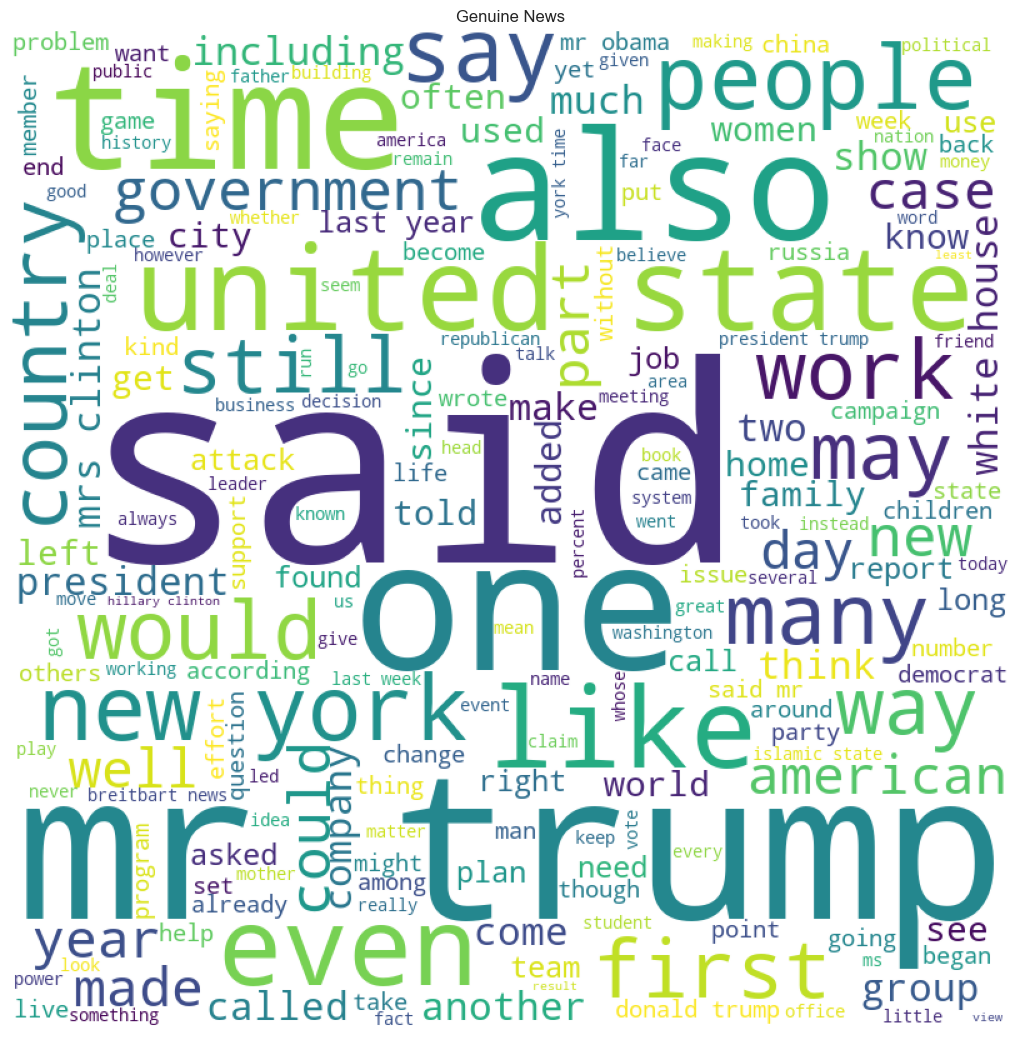

In [51]:
# Create a string of all texts and created the wordcloud

all_texts_gen = " ".join(train_df[train_df['label'] == 0]['text_joined'])
all_texts_fake = " ".join(train_df[train_df['label'] == 1]['text_joined'])

from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(all_texts_gen)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Genuine News")
plt.show()

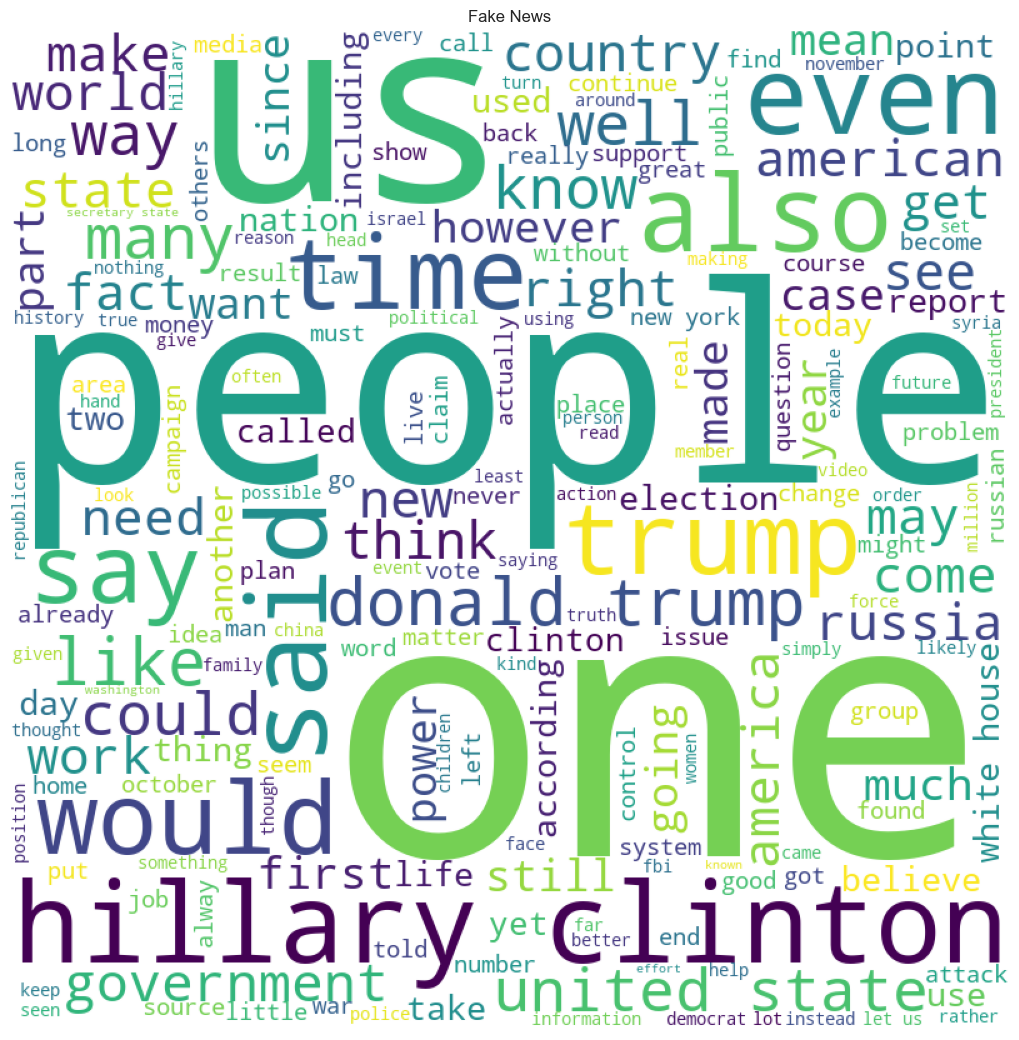

In [52]:
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(all_texts_fake)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Fake News")
plt.show()

In [53]:
original_train_df['sent_tokens'] = original_train_df['text'].apply(sent_tokenize)

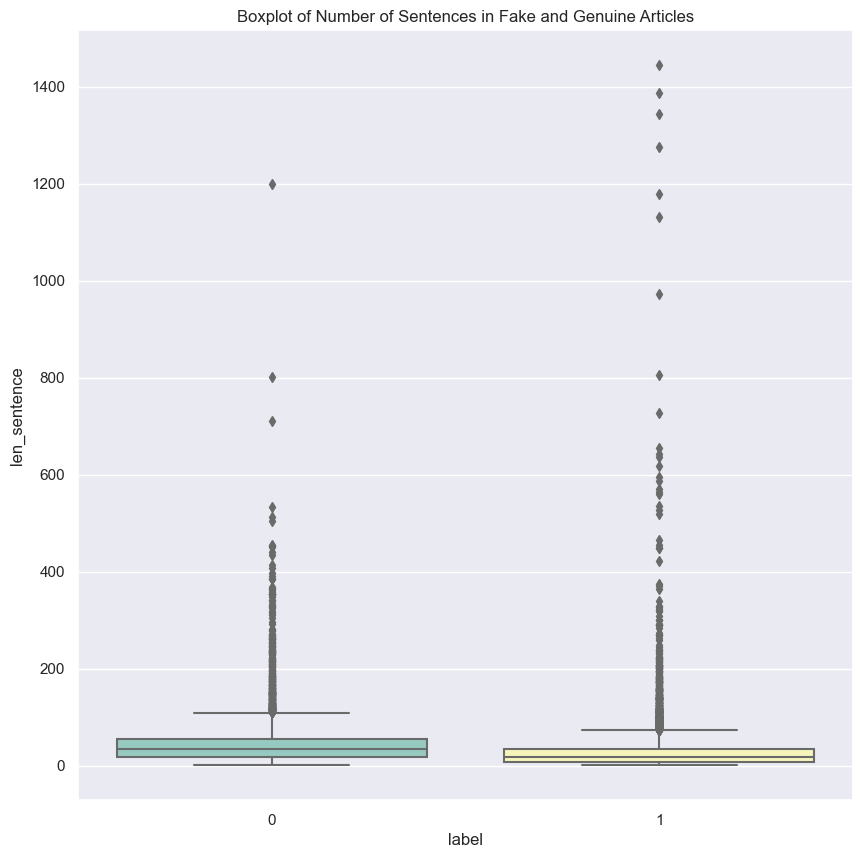

In [54]:
original_train_df['len_sentence'] = original_train_df['sent_tokens'].apply(len)
sns.boxplot(y='len_sentence', x='label', data=original_train_df, palette="Set3")
plt.title("Boxplot of Number of Sentences in Fake and Genuine Articles")
plt.show()

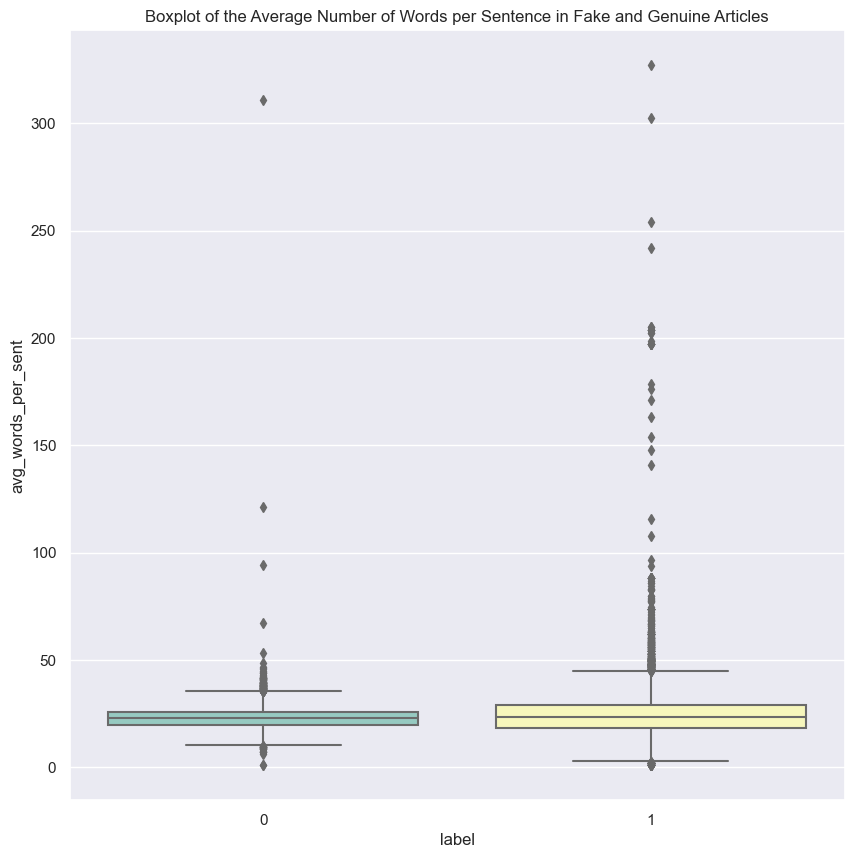

In [55]:
# Average No. of Words per Sentence Article
original_train_df['sent_word_tokens'] = original_train_df['sent_tokens'].apply(
    lambda x: [word_tokenize(each_sentence) for each_sentence in x])


def get_seq_tokens_cleaned(seq_tokens):
    no_punc_seq = [each_seq.translate(str.maketrans('', '', string.punctuation)) for each_seq in seq_tokens]
    sent_word_tokens = [word_tokenize(each_sentence) for each_sentence in no_punc_seq]
    return sent_word_tokens


original_train_df['sent_word_tokens'] = original_train_df['sent_tokens'].apply(lambda x: get_seq_tokens_cleaned(x))


def get_average_words_in_sent(seq_word_tokens):
    return np.mean([len(seq) for seq in seq_word_tokens])


original_train_df['avg_words_per_sent'] = original_train_df['sent_word_tokens'].apply(
    lambda x: get_average_words_in_sent(x))
sns.boxplot(y='avg_words_per_sent', x='label', data=original_train_df, palette="Set3")
plt.title("Boxplot of the Average Number of Words per Sentence in Fake and Genuine Articles")
plt.show()

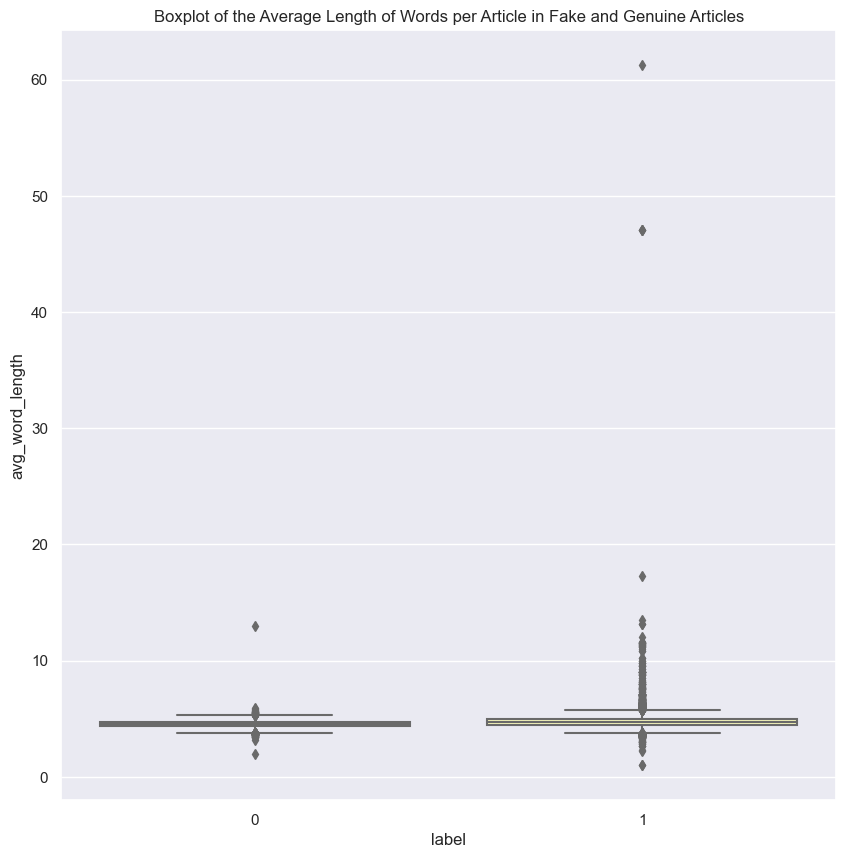

In [56]:
# Average Word Length per Article

def get_average_word_length(seq_word_tokens):
    return np.mean([len(word) for seq in seq_word_tokens for word in seq])


original_train_df['avg_word_length'] = original_train_df['sent_word_tokens'].apply(lambda x: get_average_word_length(x))

sns.boxplot(y='avg_word_length', x='label', data=original_train_df, palette="Set3")
plt.title("Boxplot of the Average Length of Words per Article in Fake and Genuine Articles")
plt.show()

In [57]:
# POS Tag Counts

all_tokenized_gen = [a for b in train_df[train_df['label'] == 0]['text'].tolist() for a in b]
all_tokenized_fake = [a for b in train_df[train_df['label'] == 1]['text'].tolist() for a in b]

len(all_tokenized_gen), len(all_tokenized_fake)

(5100290, 3701992)

In [58]:
def get_post_tags_list(tokenized_articles):
    all_pos_tags = []
    for word in tokenized_articles:
        pos_tag = nltk.pos_tag([word])[0][1]
        all_pos_tags.append(pos_tag)
    return all_pos_tags

In [1]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

NameError: name 'nltk' is not defined

In [ ]:
all_pos_tagged_word_gen = get_post_tags_list(all_tokenized_gen)
all_pos_tagged_word_fake = get_post_tags_list(all_tokenized_fake)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gokul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Gokul\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gokul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
all_pos_tagged_word_gen[:5], all_pos_tagged_word_fake[:5]

In [ ]:
from collections import Counter

gen_pos_df = pd.DataFrame(dict(Counter(all_pos_tagged_word_gen)).items(), columns=['Pos_tag', 'Genuine News'])
fake_pos_df = pd.DataFrame(dict(Counter(all_pos_tagged_word_fake)).items(), columns=['Pos_tag', 'Fake News'])

In [ ]:
pos_df = gen_pos_df.merge(fake_pos_df, on='Pos_tag')

In [ ]:
pos_df['Genuine News'] = pos_df['Genuine News'] * 100 / pos_df['Genuine News'].sum()
pos_df['Fake News'] = pos_df['Fake News'] * 100 / pos_df['Fake News'].sum()

## Text Classification

In [ ]:
# Tf-idf and Count Vectorizer
train_df['text_joined'] = train_df['text'].apply(lambda x: " ".join(x))
test_df['text_joined'] = test_df['text'].apply(lambda x: " ".join(x))

target = train_df['label'].values

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
tf_idf_transformer = TfidfTransformer(smooth_idf=False)

# fit train data to count vectorizer
count_vectorizer.fit(train_df['text_joined'].values)
count_vect_train = count_vectorizer.transform(train_df['text_joined'].values)

# fit ngrams count to tfidf transformers
tf_idf_transformer.fit(count_vect_train)
tf_idf_train = tf_idf_transformer.transform(count_vect_train)

In [ ]:
# Transform the test data as well
count_vect_test = count_vectorizer.transform(test_df['text_joined'].values)
tf_idf_test = tf_idf_transformer.transform(count_vect_test)

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(tf_idf_train, target, random_state=0)
df_perf_metrics = pd.DataFrame(
    columns=['Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision', 'Recall', 'f1_score'])

## Training the model

In [ ]:
model = LogisticRegression()

max_iter = [50, 75, 100]
C = [75, 100, 125]

param_grid = dict(max_iter=max_iter, C=C)

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=2)

grid_result = grid.fit(X_train, y_train)

In [ ]:
model = grid_result.best_estimator_
y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('f1-score: ', f1_score(y_test, y_pred))

In [ ]:
grid_result.best_params_

# Ranking System
Here we get top 10 news articles through Microsoft Bing api
Then we scrap all 10 website
Process each article
Predict the score of each article and print in order of their rank

Input : A particular topic to get news on